In [1]:
# What we aim to do here is numerically simulate a package of gfp molecule signal linked to a stochastically-
# varying promoter state in a gene. The idea is that if we tweak our parameters in our numerical model, we 
# can then fit the numerical model to our actual fly embryo data, in order to be able to say something about
# how this gene is turned on.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import gfp_signal
from telegraph import exponential

In [493]:
# Simulate a transcription promoter using my exponentially-distributed wait time telegraph signal and
# my simulation of GFP agglomeration following an "ON" or "OFF" prompt

# make the system more likely to linger in off stage: choose k_off to be less than k_on such that
#                       mean_off = 1.0 / k_off   >    1.0 / k_on
k_on = 0.03
k_off = 0.08  
duration = 555 # seconds
stepsize = 3   # seconds / step

tel = exponential(k_on, k_off, duration, stepsize)

promoter_sig = tel.signal

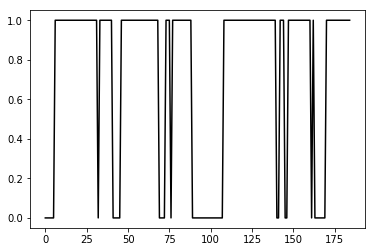

In [494]:
plt.plot(promoter_sig, color='k')

In [495]:
# Now add the numerically-simulated agglomeration of GFP stem-loops which generate the fluorescence signal we see
# parameters
sig = promoter_sig
k_gfp = 3       # gfp molecules / second
cts = 1000      # counts per gfp molecule
k_polII = 1     # how many polII's started per second
max_loops = 24  # max number of gfp loops that attach to each polII site

gfp = gfp_signal.gfp_signal(telegraph=sig, k_gfp=k_gfp, k_polII=k_polII, cts_per_gfp=cts, max_loops=max_loops, stepsize=3)

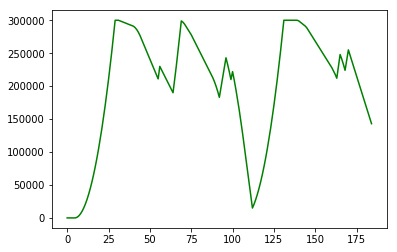

In [496]:
plt.plot(gfp.counts, color='g')

In [416]:
def autocorrelation (x) :
    """
    Compute the autocorrelation of the signal, based on the properties of the
    power spectral density of the signal.
    """
    xp = x-np.mean(x)
    f = np.fft.fft(xp)
    p = np.array([np.real(v)**2+np.imag(v)**2 for v in f])
    pi = np.fft.ifft(p)
    return np.real(pi)[:x.size/2]/np.sum(xp**2)

In [417]:
ac = autocorrelation(gfp.counts)
plt.plot(ac)

TypeError: slice indices must be integers or None or have an __index__ method

In [473]:
# Now let's simulate this ~80 times to simulate what we get from actual data.
# Parameters:
k_on = 0.03
k_off = 0.03  
duration = 575 # seconds
stepsize = 3   # seconds / step

k_gfp = 3       # gfp molecules / second
cts = 1000      # counts per gfp molecule
k_polII = 1     # how many polII's started per second
max_loops = 24  # max number of gfp loops that attach to each polII site


num = 80               # number of traces in our simulated dataset
auto_traces = []       # empty list of autocorrelation arrays
traces = []            # empty list of traces 

for i in range(num):
    tel = exponential(k_on, k_off, duration, stepsize)  # create a new signal every time      
    gfp = gfp_signal.gfp_signal(telegraph=tel.signal, k_gfp=k_gfp, k_polII=k_polII, cts_per_gfp=cts, max_loops=max_loops, stepsize=3)
    traces.append(gfp.norm)
    
    auto_trace = np.correlate(gfp.norm, gfp.norm, 'same')
    auto_traces.append(auto_trace / (np.std(gfp.norm) * np.std(gfp.norm)))   # divide each auto trace by the standard deviation squared to normalize

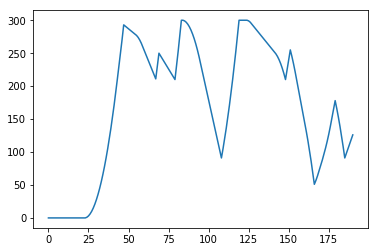

In [482]:
plt.plot(traces[3])
plt.show()

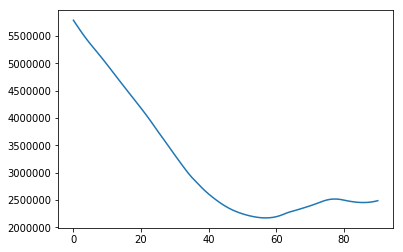

In [503]:
plt.plot((np.correlate(traces[2],traces[2], 'same'))[100:])
plt.show()

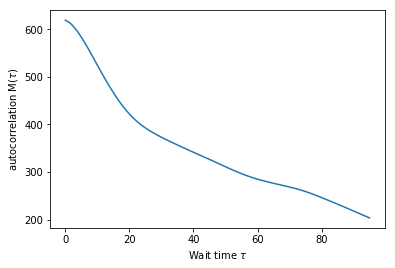

In [462]:
# Now compute the average correlation function from the set of 70.
# We see that the autocorrelation function appears as a decay curve
mean_auto_data = np.mean(auto_traces, axis = 0)
plt.plot((mean_auto_data[np.argmax(mean_auto_data):]))   # plot only half of the autocorrelation function (symmetric on both sides of max)


t = np.linspace(start=0,stop=100 )

plt.xlabel(r'Wait time $\tau$')
plt.ylabel(r'autocorrelation M($\tau$)')
plt.show()

In [463]:
# create a routine that bootstraps a set of data arrays according to Coulon & Lardon (2016)

cutoff = np.argmax(mean_auto_data)    # take only the right half of autocorrelation fns, based on our og dataset's max
traces = np.asarray(traces)           # convert to a numpy array to play with indices
n_traces = len(traces)                # number of traces in our dataset
n_trials = 1000                      # how many times we wish to compute the bootstrap loop
trace_indx = np.arange(n_traces)      # the index range of the list of traces
auto_averages = []                    # list of averaged autocorrelation functions (should be n_trials long)


# sample randomly, with replacement, a new set of n_traces 10,000 times
for i in range(n_trials):
    
    # from our list of traces, sample radomly the trace_index of these datum in the list
    random_indx = np.random.choice(trace_indx, size=n_traces, replace=True)  
    
    # then use this array of indices to create our random package of traces
    sample_set = traces[random_indx]
    auto_list = []
    
    # next compute the autocorrelation function from this package of traces
    for sample in sample_set:
        aut = np.correlate(sample, sample, 'same')
        auto_list.append(aut / (np.std(sample) * np.std(sample)))   # normalize each correlation for easy fitting later
    
    auto_mu = np.mean(auto_list, axis=0)      # now average together the autocorrelation functions from the list    
    auto_averages.append(auto_mu[cutoff:])    # add the right half of the average to the list of average autocorrelation functions


In [464]:
auto_averages = np.asarray(auto_averages)

In [465]:
# now let's compute the standard deviations of the set of 10000 autocorrelation functions. This is the STANDARD ERROR
# on our dataset
# compute at each time step (tau):
std_dev_arr = np.std(auto_averages, axis=0)

In [466]:
len(std_dev_arr)

96

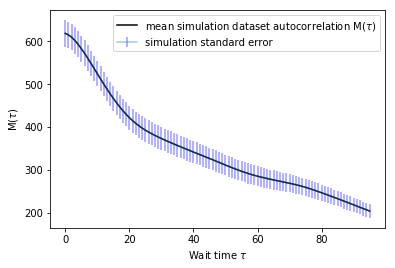

<Figure size 432x288 with 0 Axes>

In [486]:
tau = np.arange(len(mean_auto_data[cutoff:]))   # tau array to plot against

plt.errorbar(x=tau, y=mean_auto_data[cutoff:], yerr=(std_dev_arr, std_dev_arr), ecolor='b', alpha=0.4, label = 'simulation standard error')  

# show the mean of our original dataset in red
plt.plot(tau, mean_auto_data[cutoff:], color='k', label = r'mean simulation dataset autocorrelation M($\tau$)')
plt.legend()
plt.xlabel(r'Wait time $\tau$')
plt.ylabel(r'M($\tau$)')
plt.show()

plt.savefig('/Users/tmakinen/Documents/plots/errorbar.png', dpi='figure', bbox_inches='tight', overwrite=True)

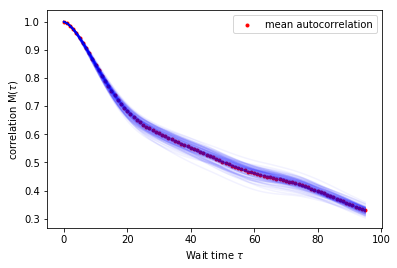

In [490]:
for i in auto_averages[::10]:
    plt.plot(i/np.max(i), color='b', alpha=0.05)   # plot a bunch of our traces to see error zones
    
plt.scatter(tau, mean_auto_data[cutoff:] /np.max(mean_auto_data[cutoff:]), marker='.', color='r', label = 'mean autocorrelation')   # show the mean of our original dataset in red
plt.legend()
plt.xlabel(r'Wait time $\tau$')
plt.ylabel(r'correlation M($\tau$)')
plt.show()

In [469]:
def decay_model(x, a):
    return np.exp(-x*a)

In [470]:
from scipy.optimize import curve_fit

popt,pcov = curve_fit(decay_model, tau, mean_auto_data[cutoff:] / np.max(mean_auto_data[cutoff:]))


In [471]:
popt

array([0.01323713])

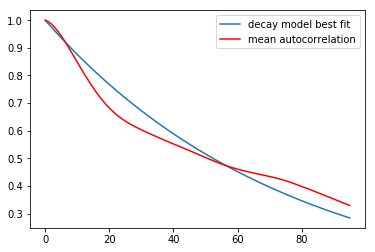

In [472]:
#plt.plot(tau, mean_auto_data[cutoff:])
plt.plot(tau, decay_model(tau, popt[0]), label='decay model best fit')
plt.plot(mean_auto_data[cutoff:] / np.max(mean_auto_data[cutoff:]), color='r', label = 'mean autocorrelation')   # show the mean of our original dataset in red
plt.legend()
plt.show()

In [432]:
""""
Autocorrelation function analysis using Despond et al's two-state model
parameters:
    p_on: probability that system is in an on state, p_on = k_on / k_off + k_on
    k_on: given as 1/mu for exponential distribution of ON wait times
    k_off: 1/mu for exponential distribution of OFF wait times
    k_gfp: gfp loop agglomeration rate such that L(t) = k_gfp*t, L(t) !> maxloops
    maxloops: max number of gfp loops allowed in chain
    """


def autocorr(k_on, k_off, t):  # take in parameters and t (index of signal data array)
    
    #k_on = pars[0]
    #k_off = pars[1]
    
    stepsize = 3   # seconds / step

    k_gfp = 3       # gfp molecules / second
    cts = 1000      # counts per gfp molecule
    k_polII = 1     # how many polII's started per second
    max_loops = 24  # max number of gfp loops that attach to each polII site
    
    
    v_elg = 1/6     # elongation rate of GFP MS2 loop chain
    timestep = 3
    v_elg_step = v_elg * timestep  # elongation rate by timestep
    maxloops = 24   # max number of loops allowed in chain
    r=maxloops      # index

    loop = np.arange(1, maxloops+1, v_elg_step).astype(int)  # loop function that describes GFP MS2 loop aggregation
    
    # write analytic autocorrelation function according to Desponds et al:
    
    delta = 1 - k_on - k_off
    
    p_on = k_on / (k_on + k_off)
    p_off = (1-p_on)
    
    
    # write a for loop to do the double sums:
    sm = 0
    for i in np.arange(1,r+1):
        for j in np.arange(1,r+1):
            sm += (loop[i] * loop[j] * np.exp((delta-1)*(i-j)))
    
    return sm*p_on*p_off*np.exp((delta - 1) * np.abs(t)) / (sm*p_on*p_off)
    

In [433]:
tau

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

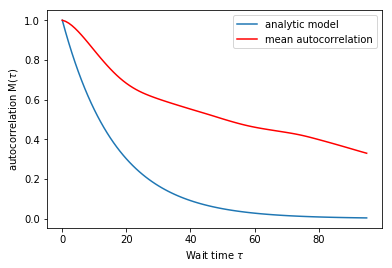

In [500]:
ac = autocorr(0.03, 0.03, tau)
plt.plot(ac, label='analytic model')#/ np.max(ac))
plt.plot(mean_auto_data[cutoff:] / np.max(mean_auto_data[cutoff:]), color='r', label = 'mean autocorrelation')   # show the mean of our original dataset in red
plt.legend(loc='best')
plt.xlabel(r'Wait time $\tau$')
plt.ylabel(r'autocorrelation M($\tau$)')
plt.show()

In [381]:
tau

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

In [393]:
from scipy.optimize import curve_fit

popt,pcov = curve_fit(autocorr, tau, mean_auto_data[cutoff:]/ np.max(mean_auto_data[cutoff:]))


popt

#plt.plot(tau, mean_auto_data[cutoff:])
plt.plot(tau, decay_model(tau, popt[0]), label='decay model best fit')
plt.plot(mean_auto_data[cutoff:] / np.max(mean_auto_data[cutoff:]), color='r', label = 'mean autocorrelation')   # show the mean of our original dataset in red
plt.legend()
plt.show()

C:\Users\tmakinen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in multiply
C:\Users\tmakinen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

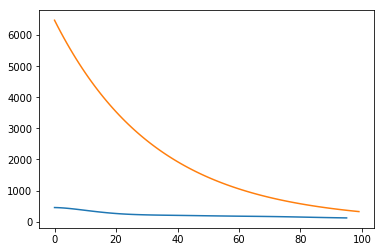

In [378]:
plt.plot(tau,mean_auto_data[cutoff:])
plt.plot(ac)

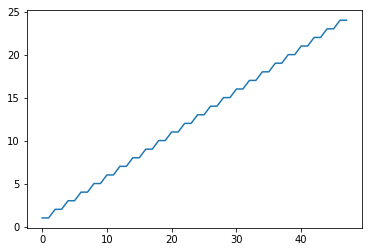

In [333]:
plt.plot(loop)


In [318]:
sm

28370.975582193005

In [323]:
t = np.linspace(start=0, stop=100, num=100)

In [328]:
test = sm * 0.6*(1-0.6)*np.exp(-0.06 * t)

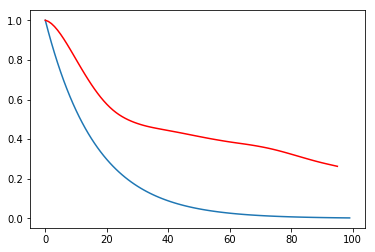

In [329]:
plt.plot(test / (np.max(test)))
plt.plot(mean_auto_data[cutoff:] / np.max(mean_auto_data[cutoff:]), color='r', label = 'mean autocorrelation')   # show the mean of our original dataset in red


In [199]:
class AutocorrelationModel(object):
    def __init__(self, tau, )

SyntaxError: invalid syntax (<ipython-input-199-aad384ea8fde>, line 2)